In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas


In [8]:
def faf_state_process_data():

    df_all = pd.read_csv('../data/FAF5.2_State_with_name.csv')
    df_all = df_all.loc[df_all['sctg2'] == 21] # selecting only pharmatheutical products 


    column_names_2017 = ['Unnamed: 0', 'fr_orig', 'dms_origst', 'dms_destst', 'fr_dest',
        'fr_inmode', 'dms_mode', 'fr_outmode', 'sctg2', 'trade_type',
        'tons_2017', 'value_2017']

    df_all = df_all.loc[:,column_names_2017]
    df_all['dms_origst'] = df_all['dms_origst'].apply(lambda x: str(x))
    df_all['dms_destst'] = df_all['dms_destst'].apply(lambda x: str(x))

    return df_all


def calculate_inflow_transportation_dependencies(df, type):
    if type == 'weight':
        df_temp = df.groupby(['dms_destst','dms_mode'])['tons_2017'].sum().reset_index()
        df_temp2 = df.groupby(['dms_destst'])['tons_2017'].sum().reset_index()
        result = df_temp.merge(df_temp2, left_on='dms_destst',right_on='dms_destst')
        result = result.rename(columns={'tons_2017_x':'ktons','tons_2017_y':'total_ktons'})
        result['pct'] = result['ktons']/result['total_ktons']
    elif type == 'value': 
        df_temp = df.groupby(['dms_destst','dms_mode'])['value_2017'].sum().reset_index()
        df_temp2 = df.groupby(['dms_destst'])['value_2017'].sum().reset_index()
        result = df_temp.merge(df_temp2, left_on='dms_destst',right_on='dms_destst')
        result = result.rename(columns={'value_2017_x':'ktons','value_2017_y':'total_ktons'})
        result['pct'] = result['ktons']/result['total_ktons']
    else:
        raise Exception("Type not specified. ")

    return result


def calculate_outflow_transportation_dependencies(df, type):
    if type == 'weight':
        df_temp = df.groupby(['dms_origst','dms_mode'])['tons_2017'].sum().reset_index()
        df_temp2 = df.groupby(['dms_origst'])['tons_2017'].sum().reset_index()
        result = df_temp.merge(df_temp2, left_on='dms_origst',right_on='dms_origst')
        result = result.rename(columns={'tons_2017_x':'ktons','tons_2017_y':'total_ktons'})
        result['pct'] = result['ktons']/result['total_ktons']
    elif type == 'value': 
        df_temp = df.groupby(['dms_origst','dms_mode'])['value_2017'].sum().reset_index()
        df_temp2 = df.groupby(['dms_origst'])['value_2017'].sum().reset_index()
        result = df_temp.merge(df_temp2, left_on='dms_origst',right_on='dms_origst')
        result = result.rename(columns={'value_2017_x':'ktons','value_2017_y':'total_ktons'})
        result['pct'] = result['ktons']/result['total_ktons']
    else:
        raise Exception("Type not specified. ")

    return result


In [9]:
df_all = faf_state_process_data()


df_domestic = df_all.loc[df_all['trade_type']==1]
df_import = df_all.loc[df_all['trade_type']==2]
df_export = df_all.loc[df_all['trade_type']==3]

In [26]:
def process_transportation_risk():
    df_t = pd.read_excel('../data/Transportation_Risk.xlsx',sheet_name='infra capacity')
    df_t = df_t.fillna(0)
    df_t['ground'] = (df_t['Bridges'] + df_t['Miles of public road']) / df_t['Grand Total']
    df_t['rail'] = df_t['Miles of freight railroad'] / df_t['Grand Total']
    df_t['water'] = df_t['Miles of inland waterway'] / df_t['Grand Total']

    df_t.loc[df_t['States']=='District of Columbia', 'States'] = 'Washington DC'
    df_t = df_t.loc[~df_t['States'].isin(['Puerto Rico','United States'])].reset_index(drop=True)

    return df_t


def cross_entropy(p,q):
    return -np.sum(np.multiply(p,np.log(q+1e-5)))



def calculate_transportation_cross_entropy(df_transport, df_t):

    dms_mode_dict = {
        1: 'truck',
        2: 'rail',
        3: 'water',
        4: 'air',
        5: 'multiple'
    }
    
    try: 
        states = df_transport['dms_destst'].unique()
    except:
        states = df_transport['dms_origst'].unique()
    states.sort()


    transport_dict = {
        key: [0]*9 for key in states
    }

    for index, row in df_transport.iterrows():
        try: 
            transport_dict[row['dms_destst']][row['dms_mode']] = row['pct']
        except:
            transport_dict[row['dms_origst']][row['dms_mode']] = row['pct']


    df_transport_transform = pd.DataFrame(columns=['state','truck','rail','water','air','multiple'])

    df_transport_transform = pd.DataFrame.from_dict(transport_dict,orient='index').reset_index()
    df_transport_transform = df_transport_transform.drop(columns=[0,6,7,8])
    df_transport_transform = df_transport_transform.rename(columns=dms_mode_dict)
    df_transport_transform = df_transport_transform.rename(columns={'index':'states'})

    df_temp = df_transport_transform.merge(df_t, left_on='states', right_on='States')
    df_temp['Truck'] = df_temp['truck'] + df_temp['multiple'] * df_temp['ground']
    df_temp['Rail'] = df_temp['rail_x'] + df_temp['multiple'] * df_temp['rail_y']
    df_temp['Water'] = df_temp['water_x'] + df_temp['multiple'] * df_temp['water_y']
    df_temp = df_temp[['States','Truck','Rail','Water']]

    df_temp['Truck_pct'] = df_temp['Truck']/(df_temp['Truck']+df_temp['Rail']+df_temp['Water'])
    df_temp['Rail_pct'] = df_temp['Rail']/(df_temp['Truck']+df_temp['Rail']+df_temp['Water'])
    df_temp['Water_pct'] = df_temp['Water']/(df_temp['Truck']+df_temp['Rail']+df_temp['Water'])

    df_temp = df_temp[['States','Truck_pct','Rail_pct','Water_pct']]

    df_target = df_t[['States','ground','rail','water']]



    cross_entropy_dict = {
        key: 0 for key in states
    }

    for s in states: 
        p = df_target.loc[df_target['States']==s,['ground','rail','water']].to_numpy().reshape(-1)
        q = df_temp.loc[df_temp['States']==s,['Truck_pct','Rail_pct','Water_pct']].to_numpy().reshape(-1)
        cross_entropy_dict[s] = cross_entropy(p,q)


    df_cross_entropy = pd.DataFrame.from_dict(cross_entropy_dict,orient='index')
    df_cross_entropy = df_cross_entropy.rename(columns={0: 'Cross Entropy'})

    return df_cross_entropy
    

In [21]:
df_inflow_transport_weight = calculate_inflow_transportation_dependencies(df_all, 'weight')
df_inflow_transport_value = calculate_inflow_transportation_dependencies(df_all, 'value')

df_outflow_transport_weight = calculate_outflow_transportation_dependencies(df_all, 'weight')
df_outflow_transport_value = calculate_outflow_transportation_dependencies(df_all, 'value')

df_t = process_transportation_risk()

In [59]:
df_cross_entropy_inflow_weight = calculate_transportation_cross_entropy(df_inflow_transport_weight, df_t)
df_cross_entropy_inflow_value = calculate_transportation_cross_entropy(df_inflow_transport_value, df_t)
df_cross_entropy_outflow_weight = calculate_transportation_cross_entropy(df_outflow_transport_weight, df_t)
df_cross_entropy_outflow_value = calculate_transportation_cross_entropy(df_outflow_transport_value, df_t)


In [29]:
shape_path = '../data/FAF_shapefiles/2017_CFS_Metro_Areas_with_FAF.shp'
shape_file=geopandas.read_file(shape_path)

In [30]:
shape_file.loc[:,"FAF_State"]=shape_file.FAF_Zone.map(lambda x: x[:2]).astype(int)
shape_file.FAF_Zone=shape_file.FAF_Zone.astype(int)

In [32]:
def map_overlay(data,right_on,sc_column,left_on="FAF_Zone",title=""):
  # merge on to map
  data_map = pd.merge(shape_file,data,left_on=left_on,right_on=right_on,how="left")

  # plot the map (with Hawaii cropped out)
  fig, ax = plt.subplots(1, 1,figsize=(20,10))
  ax=data_map.plot(ax=ax,column=sc_column,legend=True,missing_kwds={'color': 'lightgrey'})
  ax.set_axis_off()
  plt.xlim([-190, -60]) 
  if title:
    plt.title(title,fontsize=20)
  plt.show()

In [41]:
####################################
# state names <=> numerical labels #
####################################
num_state_path = '../data/FAF5_metadata.xlsx'

num_state = pd.read_excel(num_state_path, 'State', index_col=0)

num_state_map = num_state.to_dict()["Description"]

state_num = pd.read_excel(num_state_path, 'State', index_col=1)
state_num_map = state_num.to_dict()["Numeric Label"]

# DC has multiple names in str
state_num_map["District of Columbia"]=11

In [71]:
temp_in_weight = df_cross_entropy_inflow_weight.reset_index()
temp_in_weight['state'] = temp_in_weight['index'].map(state_num_map)

temp_in_value = df_cross_entropy_inflow_value.reset_index()
temp_in_value['state'] = temp_in_value['index'].map(state_num_map)

temp_out_weight = df_cross_entropy_outflow_weight.reset_index()
temp_out_weight['state'] = temp_out_weight['index'].map(state_num_map)

temp_out_value = df_cross_entropy_outflow_value.reset_index()
temp_out_value['state'] = temp_out_value['index'].map(state_num_map)

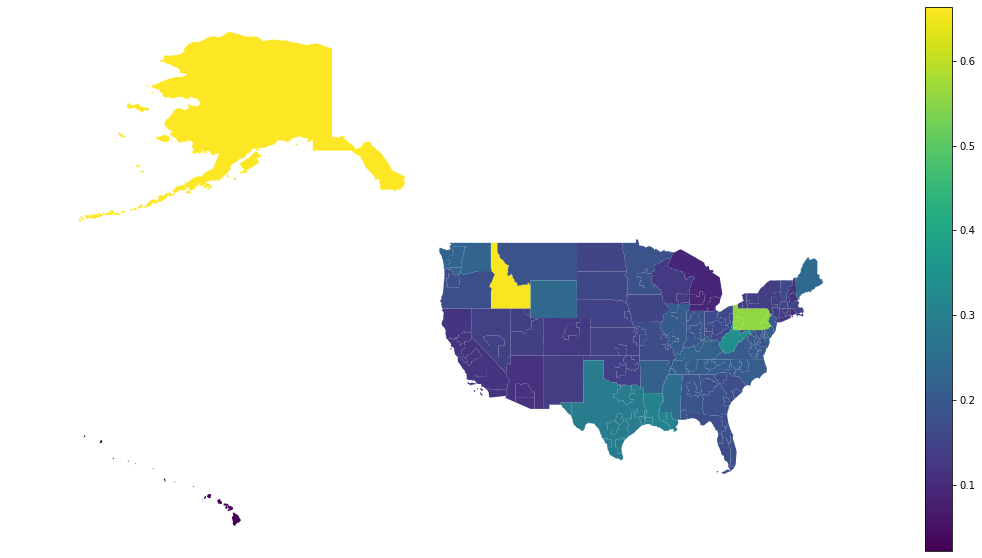

In [67]:
map_overlay(temp_in_weight, 'state', 'Cross Entropy', left_on= 'FAF_State')

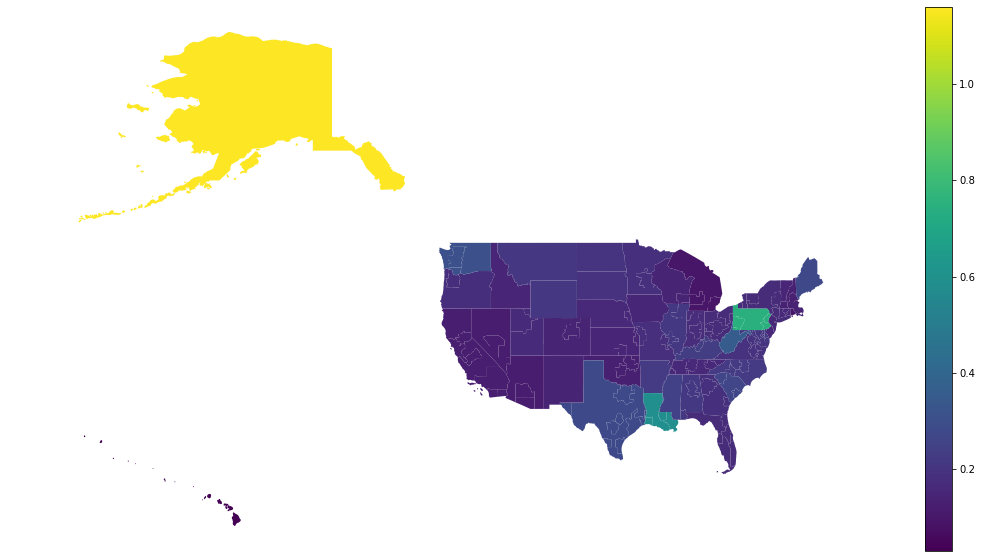

In [68]:
map_overlay(temp_out_weight, 'state', 'Cross Entropy', left_on= 'FAF_State')

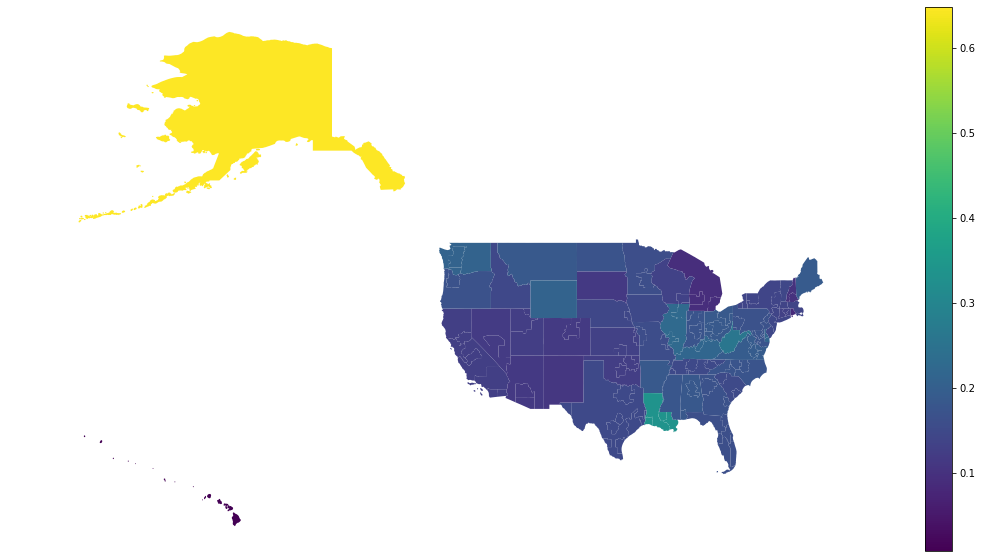

In [69]:
map_overlay(temp_in_value, 'state', 'Cross Entropy', left_on= 'FAF_State')

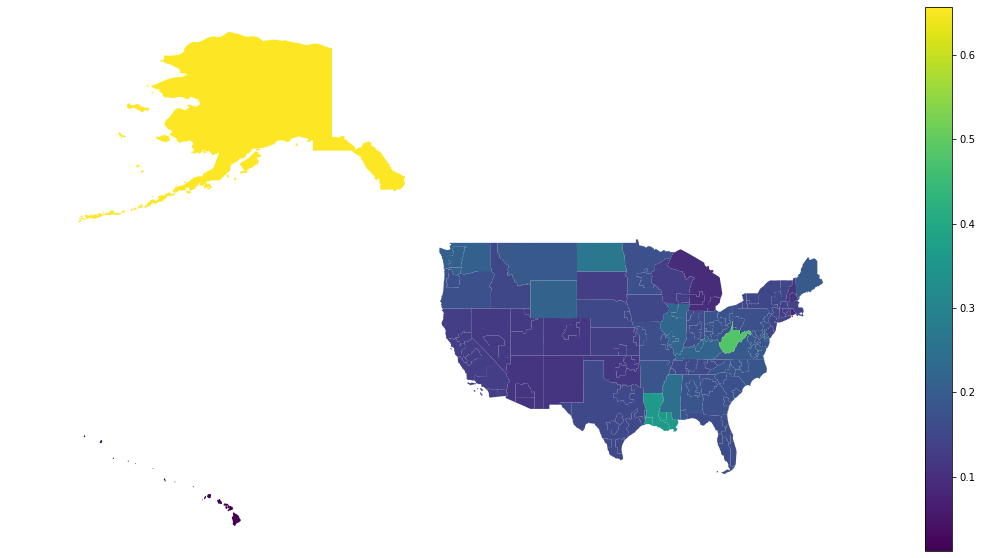

In [72]:
map_overlay(temp_out_value, 'state', 'Cross Entropy', left_on= 'FAF_State')